__1. Import the required libraries.__

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

__2.Define the train and test dataset loader.__

In [2]:
# Setting up the directories to read the data
train_directory = 'root/train'
test_directory = 'root/test'

In [3]:
def loadTrainTest(train_dir, test_dir, batch_size):
    # Transformation for image
    transformation = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5,), (0.5,))])
    
    # Load train and test dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root = train_dir, 
                                         transform = transformation)
    test_dataset = datasets.ImageFolder(root = test_dir, 
                                        transform = transformation)
    
    # Load train and test dataset into batches
    trainloader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)
    testloader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)
    return trainloader, testloader, train_dataset.classes


batch_size = int(input('Enter batch size. '))
train_load, test_load, classes = loadTrainTest(train_directory, test_directory, batch_size)

print('Classes: ', classes) # print number of classes

Enter batch size. 4
Classes:  ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


__3.Show a batch of images__

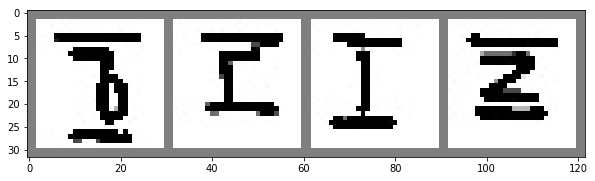

In [4]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))  # (C, H, W) ---> (H, W, C)
    else:
        image = np.array(image).transpose((1, 2, 0))
    # unnormalize
    image = 0.5*image + 0.5
    # Plot
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    
# get some random training images
images, labels = next(iter(train_load))
imshow(torchvision.utils.make_grid(images))  # show images

<br>

__4. Define the architecture of your network.__<br>___Use the following information:___
* ```Conv1```: A convolutional layer that takes the non colored image as input and passes it through ```6``` filters of size ```5```.
* ```Pool1```: Use a pooling layer after each convolutional layer, with a filter size of ```2```.
* ```Conv2```: A convolutional layer that passes the input data through ```16``` filters of size ```5```.
* ```Pool2```: Use a pooling layer after each convolutional layer, with a filter size of ```2```.
* ```Linear1```: A fully connected layer that receives the flattened matrix from the previous layer as input and generates an output of ```120``` units.
* ```Linear2```: A fully connected layer that generates ```84``` of outputs.
* ```Linear3```: A fully connected layer that generates ```10``` outputs, one for each class label. 
* Use the ```ReLU``` activation function after each convolutional layer.

In [5]:
class GeezNet(nn.Module):
    def __init__(self):
        super(GeezNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print('shape of X: 'x.shape)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GeezNet()
print(model)

GeezNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


<br>__4. Define a Loss function and optimizer__

In [6]:
def lossAndoptimizer(ls, op, lr = 1e-2):
    loss_func = {'mse': nn.MSELoss(), 'smoothL1': nn.SmoothL1Loss(), 'l1': nn.L1Loss(), 
                 'entropy' : nn.CrossEntropyLoss(), 'hinge': nn.HingeEmbeddingLoss(), 
                 'nll': nn.NLLLoss() }
    
    optimizer_func = {'sgd': optim.SGD(model.parameters(), lr, momentum=0.9), 'adam': optim.Adam(model.parameters(), lr),
                     'adagrad': optim.Adagrad(model.parameters(), lr)}
    return loss_func[ls], optimizer_func[op]


loss_f = input(''' Write the type of loss function you want.
                        'mse' for MSELoss 
                        'smoothL1' for nSmoothL1Loss 
                        'l1' for L1Loss 
                        'entropy' for CrossEntropyLoss 
                        'hinge' for HingeEmbeddingLoss  
                        'nll' for NLLLoss \n''')

print()
optimizer_f = input('''Write the type of optimizer function you want.
                        'sgd' for SGD 
                        'adam' for Adam 
                        'adagrad' for Adagrad \n''')

print(f'\nSelected loss function: {loss_f} \nSelected optimizer function: {optimizer_f}')
criterion, optimizer = lossAndoptimizer(loss_f, optimizer_f)

 Write the type of loss function you want.
                        'mse' for MSELoss 
                        'smoothL1' for nSmoothL1Loss 
                        'l1' for L1Loss 
                        'entropy' for CrossEntropyLoss 
                        'hinge' for HingeEmbeddingLoss  
                        'nll' for NLLLoss 
entropy

Write the type of optimizer function you want.
                        'sgd' for SGD 
                        'adam' for Adam 
                        'adagrad' for Adagrad 
sgd

Selected loss function: entropy 
Selected optimizer function: sgd


__5. Train your model.__

In [7]:
def train_model(trainload, criteria, optimizer, epochs):
    print('\nTraining started.......\n')
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0       # Set the running loss at each epoch to zero
        for i, data in enumerate(trainload):
            inputs, labels = data  # get the inputs; data is a list of [inputs, labels]
            optimizer.zero_grad()  # clear the gradient
            outputs = model(inputs) # feed the input and acquire the output from network
            loss = criterion(outputs, labels) # calculating the predicted and the expected loss
            loss.backward()    # Backpropagation
            optimizer.step()    # update the parameters
            # print statistics
            running_loss += loss.item()
            if i % 96 == 0: # print every 96 mini-batches
                print(f"ephoch {epoch + 1}, loss {loss.item():.4f}")
                print('-----------------------')
    print('\nFinished Training!')
    return model
    
epochs = int(input('Enter the number of epochs. '))    
model = train_model(train_load, criterion, optimizer, epochs)

Enter the number of epochs. 2

Training started.......

ephoch 1, loss 2.2557
-----------------------
ephoch 1, loss 2.2322
-----------------------
ephoch 1, loss 1.6288
-----------------------
ephoch 2, loss 1.3362
-----------------------
ephoch 2, loss 0.6163
-----------------------
ephoch 2, loss 0.8078
-----------------------

Finished Training!


__6.Testing the model.__

GroundTruth:      6    10     7     8


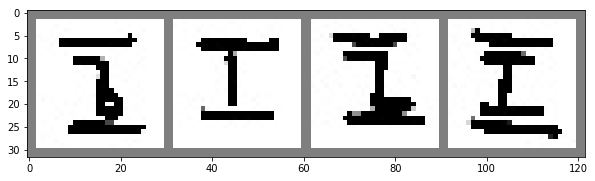

In [8]:
""" 
get some random testing images
make an iterator from test_loader
Get a batch of training images
"""
images, labels = next(iter(test_load))

# print images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Predicted:      6    10     6     8


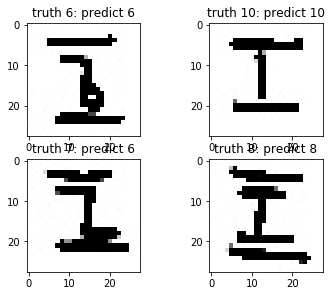

In [9]:
results = model(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

fig2 = plt.figure()
plt.subplots_adjust(top = 0.99)
for i in range(batch_size):
    fig2.add_subplot(2,2, i+1)
    plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()

In [10]:
# Network performance
def accuracy(model, test_load):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_load:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total, correct, total

acc, correct, total  = accuracy(model, test_load)
print(f'Accuracy of the network on the {total} test images is: {acc}')
print(f'{correct} images out of {total} are correctly predicted')

Accuracy of the network on the 40 test images is: 72.5
29 images out of 40 are correctly predicted
